In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy as sp
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.10'

In [2]:
def position(x, bino, start_anti, v_anti, latence, tau, maxi, nan=False, do_numpy=True):
    
    saccades = data[trial_data]['events']['Esac'] #[starttime, endtime, duration, startx, starty, endx, endy]
    data_x = data[trial_data]['x']
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    v_anti = (v_anti/1000) #/ms # pour passer de sec à ms
    maxi = maxi /ms
    
    speed = ANEMO.fct_exponentiel(x, bino, start_anti, v_anti, latence, tau, maxi)
    pos = np.cumsum(speed)

    if nan == True :
        avant, apres =  5, 10 #15
        for sacc in saccades :
            if sacc[0]-t_0 < len(pos) :
                if sacc[0]-t_0 > int(latence) :
                    if int(sacc[1]-t_0)+apres <= len(pos) :
                        # [starttime, endtime, duration, startx, starty, endx, endy]
                        #pos[int(sacc[1]-t_0+1):] += (sacc[5]-sacc[3])/ exp['px_per_deg'] - np.sum(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]
                        pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = np.nan 
                        pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/exp['px_per_deg']) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]

                    else :
                        pos[int(sacc[0]-t_0)-avant:] = np.nan
 
    return pos

In [3]:
def Fit_position(velocity_x, trackertime, bino,  TargetOn, StimulusOf, saccades, trial_data, param_fit=None,
                 sup=False, time_sup=-280, step=2, nan=True) :

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,0.,40], 'v_anti':[0.,-40.,40.], 'latence':[TargetOn-t_0+100,TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]}


    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0)-1)
        if stop_latence==[] :
            stop_latence.append(len(time))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]

    model = Model(position)

    params = Parameters()

    if step == 1 :
        vava = True
    elif step == 2 :
        vava = False

    params.add('nan', value=nan, vary=False)
    params.add('trial_data', value=trial_data, vary=False)
    params.add('bino', value=bino, vary=False)
    
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vava)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vava)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vava)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg


In [4]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
    
datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
screen_width_px = exp['screen_width_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


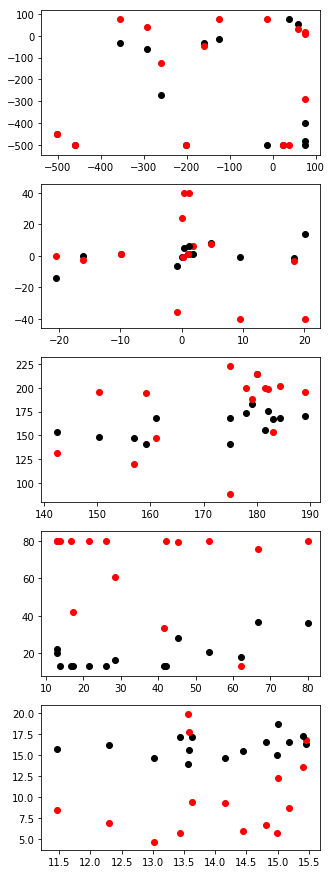

In [6]:
block = 0
#trial = 131
fig_width= 5
fig, axs = plt.subplots(5, 1, figsize=(fig_width, 5*(fig_width)/1.6180))

for trial in range(15) :
    print(trial)
    trial_data = trial + N_trials*block

    time = data[trial_data]['trackertime']
    StimulusOn = data[trial_data]['events']['msg'][10][0]
    StimulusOf = data[trial_data]['events']['msg'][14][0]
    TargetOn = data[trial_data]['events']['msg'][15][0]
    TargetOff = data[trial_data]['events']['msg'][16][0]
    saccades = data[trial_data]['events']['Esac']
    t_0 = time[0]

    DATA_x = data[trial_data]['x']
    data_x = DATA_x-(DATA_x[StimulusOf-t_0])
    #data_x = DATA_x-(exp['screen_width_px']/2)

    bino=p[trial, block, 0]

    start = TargetOn
    start1 = TargetOn-t_0
    
    
    data_da = np.copy(data_x)
  
    avant, apres =  5, 10 #15
    for s in range(len(saccades)) :
        if saccades[s][1]-t_0+apres <= (len(time)) :
            for x_data in np.arange((saccades[s][0]-t_0-avant), (saccades[s][1]-t_0+apres)) :
                data_da[x_data] = np.nan
        else :
            for x_data in np.arange((saccades[s][0]-t_0-avant), (len(time))) :
                data_da[x_data] = np.nan

    data3 = np.copy(data_da)
    a = 0
    for s in range(len(saccades)) :
        if saccades[s][1]-t_0+apres < len(data_da) :
            a = a + (data_da[saccades[s][1]-t_0+apres]-data_da[saccades[s][0]-t_0-avant-1])
        else :
            a = a + (data_da[len(data_da)-1]-data_da[saccades[s][0]-t_0-avant-1])
        b = ((data_da[saccades[s][0]-t_0-avant-1]-data_da[saccades[s][0]-t_0-avant-11])/10)           
        if s < len(saccades)-1 :
            for x_data in np.arange((saccades[s][1]-t_0+apres), (saccades[s+1][0]-t_0-avant)) :
                data3[x_data] = data3[x_data]-a + ((saccades[s][1]-t_0+apres)-(saccades[s][0]-t_0-avant))*b
        else :
            for x_data in np.arange((saccades[s][1]-t_0+apres), len(time)) :
                data3[x_data] = data3[x_data]-a +((saccades[s][1]-t_0+apres)-(saccades[s][0]-t_0-avant))*b

    data3 = data3 - data3[StimulusOf-t_0]
    data_2 = data3 * 1/exp['px_per_deg']



    a = Fit_position(data_2,time, bino, TargetOn, StimulusOf, saccades, trial_data, step=2, sup=True, nan=False)
    c = Fit_position(data_2,time, bino, TargetOn, StimulusOf, saccades, trial_data, step=2, sup=True, nan=True)
    
    axs[0].scatter(param['start_anti'][block][trial], a.values['start_anti']-start1, c='k')
    axs[0].scatter(param['start_anti'][block][trial], c.values['start_anti']-start1, c='r')
    axs[1].scatter(param['v_anti'][block][trial], a.values['v_anti'], c='k')
    axs[1].scatter(param['v_anti'][block][trial], c.values['v_anti'], c='r')
    axs[2].scatter(param['latence'][block][trial], a.values['latence']-start1, c='k')
    axs[2].scatter(param['latence'][block][trial], c.values['latence']-start1, c='r')
    axs[3].scatter(param['tau'][block][trial], a.values['tau'], c='k')
    axs[3].scatter(param['tau'][block][trial], c.values['tau'], c='r')
    axs[4].scatter(param['maxi'][block][trial], a.values['maxi'], c='k')
    axs[4].scatter(param['maxi'][block][trial], c.values['maxi'], c='r')
    
plt.show()